Предупреждение: Последний список неполный.


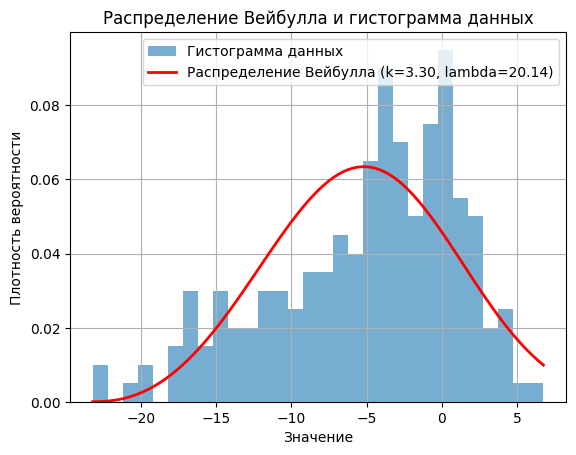

Исходные данные:
 [[-9.19, -9.6, -15.275, -13.67, -14.23, -10.64545, -1.22, -4.23, -2.42, 0.43], [-23.23, -11.55, -9.3125, -15.05, -8.09, -12.8, 0.26667, -0.01, -0.36, 3.96], [-20.21, -16.05, -14.8625, -2.89, 0.64, -0.5, -3.57, 0.4, 1.36, 1.13], [-4.2, -6.3, -9.26667, -13.53333, -6.63, -5.21818, -0.84, -3.33, -0.6, 2.7375], [-14.67, -8.91, -9.05, -5.88, -5.17778, -5.84545, -7.81, -2.51, -1.5, 2.78], [-11.9, -17.46, -17.2125, -6.7, -12.32, -6.91818, 1.85, 0.32, 1.0, 4.15], [-17.67, -20.19, -15.2125, -3.59, -5.42, -7.13636, 0.6, -0.04, 1.1, 4.2], [-20.58889, -16.25, -7.4, -8.07, -7.66, -12.3, -7.36, 0.26, 2.71, 1.77], [-3.94, -5.96, -6.7625, -16.32, -17.19, -15.92727, -6.47, 1.7, 1.45, 3.79], [-7.59, -4.45, -5.925, -1.26, -5.43, -3.40909, -6.34, 2.16, 0.27, -0.9], [-11.16, -5.23, 0.95, 0.32, 0.01, -4.36364, 0.23, -0.3, 0.22, 5.0], [-3.06, -2.89, -4.58889, -3.91, -3.82, -2.22727, 0.55, -0.02, 3.72, 6.77], [-8.89, -4.56, -9.3125, -4.02, -1.15, -2.66364, -3.33, -4.82, -1.03, 0.28], [-12.21,

In [18]:
import numpy as np
import scipy.stats as stats

def read_data(filename):
    data = []
    current_list = []
    try:
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue

                try:
                    index, value = line.split('\t')
                    value = float(value)
                    current_list.append(value)
                except ValueError:
                    print(f"Ошибка: Неверный формат строки: {line}")
                    return None

                if len(current_list) == 10:
                    data.append(current_list)
                    current_list = []  # Начинаем новый подсписок

        if current_list:
            print("Предупреждение: Последний список неполный.")
            data.append(current_list + [0] * (10 - len(current_list)))

        return data

    except FileNotFoundError:
        print(f"Ошибка: Файл не найден: {filename}")
        return None
    except Exception as e:
        print(f"Ошибка при чтении файла: {e}")
        return None








import matplotlib.pyplot as plt # Добавлено для визуализации

def weibull_binning(data, num_bins, plot_fit=False): # Добавлен plot_fit
    """
    Разбивает двумерный массив данных на заданное количество отрезков (категорий) на основе
    распределения Вейбулла и возвращает не только разбитые данные, но и значения границ отрезков.
    Подходит для данных, которые могут быть отрицательными.

    Args:
        Двумерный массив данных (numpy array или список списков).
        num_bins: Количество отрезков (категорий), на которые нужно разбить данные.
        plot_fit: (bool, optional)  Если True, отображает график гистограммы данных и
                  подобранного распределения Вейбулла.  Полезно для визуальной оценки.
                  Defaults to False.

    Returns:
        tuple: (binned_data, bin_edges)
            binned_Двумерный массив с номерами отрезков.
            bin_edges:  Значения границ отрезков.
            Возвращает (None, None), если не удалось оценить параметры Вейбулла.
    """

    # 1. Преобразование данных в одномерный массив
    flat_data = data.flatten()

    # 2. Сдвиг данных (если необходимо)
    min_val = np.min(flat_data)
    if min_val < 0:
        shift = -min_val
        flat_data = flat_data + shift
    else:
        shift = 0

    # 3. Оценка параметров распределения Вейбулла
    try:
        k, loc, scale = stats.weibull_min.fit(flat_data, floc=0)
    except RuntimeError:
        print("Не удалось оценить параметры распределения Вейбулла.")
        return None, None
    except Exception as e: #Добавлено для перехвата других возможных исключений
        print(f"Произошла ошибка при оценке параметров Вейбулла: {e}")
        return None, None

    # 4. Создание границ отрезков
    percentiles = np.linspace(0, 100, num_bins + 1)
    bin_edges = stats.weibull_min.ppf(percentiles / 100, k, loc, scale)

    # 5. Сдвиг границ обратно
    bin_edges = bin_edges - shift

    # 6. Применение биннинга
    binned_flat_data = np.digitize(flat_data, bin_edges, right=False) - 1

    # 7. Обработка значений, выходящих за границы
    binned_flat_data[binned_flat_data == -1] = 0
    binned_flat_data[binned_flat_data == num_bins] = num_bins - 1

    # 8. Возврат к исходной форме
    binned_data = binned_flat_data.reshape(data.shape)

    # 9. Визуализация (по желанию) - для диагностики
    if plot_fit:
        x = np.linspace(np.min(data), np.max(data), 100)
        pdf = stats.weibull_min.pdf(x + shift, k, loc, scale) # Сдвигаем x обратно
        plt.hist(data.flatten(), bins=30, density=True, alpha=0.6, label='Гистограмма данных')
        plt.plot(x, pdf, 'r-', lw=2, label=f'Распределение Вейбулла (k={k:.2f}, lambda={scale:.2f})')
        plt.xlabel('Значение')
        plt.ylabel('Плотность вероятности')
        plt.title('Распределение Вейбулла и гистограмма данных')
        plt.legend()
        plt.grid(True)
        plt.show()

    return binned_data, bin_edges


# Пример использования
if __name__ == '__main__':
    # Пример данных
    my_data = read_data("Downloads/decANDsrTutf8.txt")[:-1] # Генерируем данные из нормального распределения

    # Важно! Попробуйте разные распределения для my_data, чтобы понять, как это влияет на результаты.
    # Например:
    # my_data = np.random.weibull(2, size=(10, 10)) * 5  # Данные, уже соответствующие Вейбуллу (форма = 2, масштаб = 5)
    # my_data = np.random.exponential(scale=5, size=(10,10)) # Экспоненциальное распределение

    num_bins = 10

    binned_data, bin_edges = weibull_binning(np.array(my_data), num_bins, plot_fit=True) # plot_fit=True для визуализации

    if binned_data is not None:
        print("Исходные данные:\n", my_data)
        print("\nРазбитые на отрезки данные:\n", binned_data)
        print("\nЗначения границ отрезков:\n", bin_edges)
        print(bin_edges)

        # Проверка распределения по отрезкам
        unique_bins, counts = np.unique(binned_data, return_counts=True)
        print("\nРаспределение значений по отрезкам:")
        for bin_num, count in zip(unique_bins, counts):
            print(f"Отрезок {bin_num}: {count} значений")
    else:
        print("Не удалось разбить данные на отрезки.")